In [1]:
import folium
from folium import Marker, GeoJson
from folium.plugins import HeatMap

import pandas as pd
import geopandas as gpd

e:\SelfLearning\Kaggle\kaggleEnv\lib\site-packages\geopandas\_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


Now, we'll work with a dataset from the US Environmental Protection Agency (EPA) that tracks releases of toxic chemicals in Philadelphia, Pennsylvania, USA.



In [3]:
releases = gpd.read_file("..\\GeoSpatialData\\toxic_release_pennsylvania\\toxic_release_pennsylvania\\toxic_release_pennsylvania.shp") 
releases.head()

,YEAR,CITY,COUNTY,ST,LATITUDE,LONGITUDE,CHEMICAL,UNIT_OF_ME,TOTAL_RELE,geometry
0,2016,PHILADELPHIA,PHILADELPHIA,PA,40.005901,-75.072103,FORMIC ACID,Pounds,0.160,POINT (2718560.227 256380.179)
1,2016,PHILADELPHIA,PHILADELPHIA,PA,39.920120,-75.146410,ETHYLENE GLYCOL,Pounds,13353.480,POINT (2698674.606 224522.905)
2,2016,PHILADELPHIA,PHILADELPHIA,PA,40.023880,-75.220450,CERTAIN GLYCOL ETHERS,Pounds,104.135,POINT (2676833.394 261701.856)
3,2016,PHILADELPHIA,PHILADELPHIA,PA,39.913540,-75.198890,LEAD COMPOUNDS,Pounds,1730.280,POINT (2684030.004 221697.388)
4,2016,PHILADELPHIA,PHILADELPHIA,PA,39.913540,-75.198890,BENZENE,Pounds,39863.290,POINT (2684030.004 221697.388)


We'll also work with a dataset that contains readings from air quality monitoring stations in the same city.

In [4]:
stations = gpd.read_file("..\GeoSpatialData\PhillyHealth_Air_Monitoring_Stations\PhillyHealth_Air_Monitoring_Stations\PhillyHealth_Air_Monitoring_Stations.shp")
stations.head()

,SITE_NAME,ADDRESS,BLACK_CARB,ULTRAFINE_,CO,SO2,OZONE,NO2,NOY_NO,PM10,...,PAMS_VOC,TSP_11101,TSP_METALS,TSP_LEAD,TOXICS_TO1,MET,COMMUNITY_,LATITUDE,LONGITUDE,geometry
0,LAB,1501 East Lycoming Avenue,N,N,Y,N,Y,Y,Y,N,...,Y,N,Y,N,y,N,N,40.008606,-75.097624,POINT (2711384.641 257149.310)
1,ROX,Eva and Dearnley Streets,N,N,N,N,N,N,N,N,...,N,N,Y,N,Y,N,N,40.050461,-75.236966,POINT (2671934.290 271248.900)
2,NEA,Grant Avenue and Ashton Street,N,N,N,N,Y,N,N,N,...,N,N,N,N,N,Y,N,40.072073,-75.013128,POINT (2734326.638 280980.247)
3,CHS,500 South Broad Street,N,N,N,N,N,N,N,N,...,N,N,Y,N,Y,N,N,39.944510,-75.165442,POINT (2693078.580 233247.101)
4,NEW,2861 Lewis Street,N,N,Y,Y,Y,N,Y,Y,...,N,Y,N,Y,N,Y,N,39.991688,-75.080378,POINT (2716399.773 251134.976)


In [5]:
print(stations.crs)
print(releases.crs)

epsg:2272
epsg:2272


We also check the CRS to see which units it uses (meters, feet, or something else). In this case, EPSG 2272 has units of feet.

It's relatively straightforward to compute distances in GeoPandas. The code cell below calculates the distance (in feet) between a relatively recent release incident in recent_release and every station in the stations GeoDataFrame.

In [7]:
# Select one release incident in particular
recent_release = releases.iloc[360]
recent_release.head()

YEAR                2012
CITY        PHILADELPHIA
COUNTY      PHILADELPHIA
ST                    PA
LATITUDE        39.91354
Name: 360, dtype: object

In [8]:
# Measure distance from release to each station
distances = stations.geometry.distance(recent_release.geometry)
distances.head()

0    44778.509761
1    51006.456589
2    77744.509207
3    14672.170878
4    43753.554393
dtype: float64

In [10]:
print('Mean distance to monitoring stations: {} feet'.format(distances.mean()))
print('Closest monitoring station ({} feet):'.format(distances.min()))
print(stations.iloc[distances.idxmin()][["ADDRESS", "LATITUDE", "LONGITUDE"]])    # Prints the closest station

Mean distance to monitoring stations: 33516.28487007786 feet
Closest monitoring station (3780.623590556444 feet):
ADDRESS      3100 Penrose Ferry Road
LATITUDE                    39.91279
LONGITUDE                 -75.185448
Name: 9, dtype: object


Creates a GeoSeries two_mile_buffer containing 12 different Polygon objects. Each polygon is a buffer of 2 miles (or, 2*5280 feet) around a different air monitoring station.

In [16]:
two_mile_buffer = stations.geometry.buffer(2*5280)
two_mile_buffer.head()

0    POLYGON ((2721944.641 257149.310, 2721893.792 ...
1    POLYGON ((2682494.290 271248.900, 2682443.441 ...
2    POLYGON ((2744886.638 280980.247, 2744835.789 ...
3    POLYGON ((2703638.580 233247.101, 2703587.731 ...
4    POLYGON ((2726959.773 251134.976, 2726908.924 ...
dtype: geometry

We use folium.GeoJson() to plot each polygon on a map. Note that since folium requires coordinates in latitude and longitude, we have to convert the CRS to EPSG 4326 before plotting.

In [17]:
# Create map with release incidents and monitoring stations
m = folium.Map(location=[39.9526,-75.1652], zoom_start=11)
HeatMap(data=releases[['LATITUDE', 'LONGITUDE']], radius=15).add_to(m)
for idx, row in stations.iterrows():
    Marker([row['LATITUDE'], row['LONGITUDE']]).add_to(m)
    
# Plot each polygon on the map
GeoJson(two_mile_buffer.to_crs(epsg=4326)).add_to(m)

# Show the map
m

Now, to test if a toxic release occurred within 2 miles of any monitoring station, we could run 12 different tests for each polygon (to check individually if it contains the point).

But a more efficient way is to first collapse all of the polygons into a MultiPolygon object. We do this with the unary_union attribute.

Type: <class 'shapely.geometry.multipolygon.MultiPolygon'>


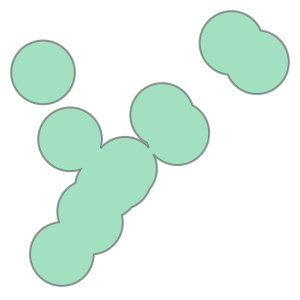

In [18]:
# Turn group of polygons into single multipolygon
my_union = two_mile_buffer.geometry.unary_union
print('Type:', type(my_union))

# Show the MultiPolygon object
my_union

We use the contains() method to check if the multipolygon contains a point. We'll use the release incident from earlier in the tutorial, which we know is roughly 3781 feet to the closest monitoring station.

In [20]:
# The closest station is less than two miles away
my_union.contains(releases.iloc[360].geometry)

True